In [1]:
# https://youtu.be/442BTP1_ZBw

"""
@author: Sreenivas Bhattiprolu
Video 166b
Data: https://github.com/CSSEGISandData/COVID-19/blob/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv
"""

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
country = "US"
#country = 'India'

#Total COVID confirmed cases
df_confirmed = pd.read_csv("https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv")



df_confirmed.to_csv('global.csv', index=False)
df_confirmed_country = df_confirmed[df_confirmed["Country/Region"] == country]
df_confirmed_country = pd.DataFrame(df_confirmed_country[df_confirmed_country.columns[4:]].sum(),columns=["confirmed"])
df_confirmed_country.index = pd.to_datetime(df_confirmed_country.index,format='%m/%d/%y')



df_confirmed_country = pd.read_csv('monthly.csv', index_col = 0, skiprows = 1, names = ['confirmed'])
df_confirmed_country.index = pd.to_datetime(df_confirmed_country.index)
display(df_confirmed_country.tail(3))
df_confirmed_country.plot(figsize=(10,5),title="COVID confirmed cases")
print("Total days in the dataset", len(df_confirmed_country))



,confirmed
2020-11-01,44.466667
2020-12-01,39.064516
2021-01-01,20.758621


Total days in the dataset 217


Total number of samples in the original training data =  203
Total number of samples in the generated data =  196
Total number of samples in the original training data =  14
Total number of samples in the generated data =  7
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 7, 150)            91200     
_________________________________________________________________
lstm_1 (LSTM)                (None, 64)                55040     
_________________________________________________________________
dense (Dense)                (None, 64)                4160      
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 65        
Total params: 150,465
Trainable params: 150,465
Non-trainable params: 0
_________________________________________________________________
Train...
Epoch 1/10
10/

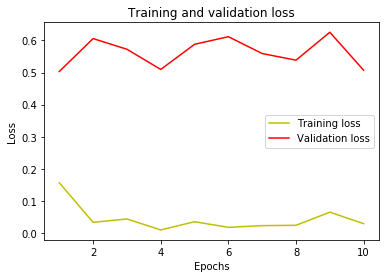

In [2]:
#Use data until 14 days before as training
x = len(df_confirmed_country)-14

train=df_confirmed_country.iloc[:x]
test = df_confirmed_country.iloc[x:]

##scale or normalize data as the data is too skewed
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
scaler.fit(train) 

train_scaled = scaler.transform(train)
test_scaled = scaler.transform(test)

## Use TimeSeriestrain_generator to generate data in sequences.
#Alternatively we can create our own sequences. 
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator

#Sequence size has an impact on prediction, especially since COVID is unpredictable!
seq_size = 7  ## number of steps (lookback)
n_features = 1 ## number of features. This dataset is univariate so it is 1
train_generator = TimeseriesGenerator(train_scaled, train_scaled, length = seq_size, batch_size=1)
print("Total number of samples in the original training data = ", len(train)) # 271
print("Total number of samples in the generated data = ", len(train_generator)) # 264 with seq_size=7

#Check data shape from generator
x,y = train_generator[10]  #Check train_generator
#Takes 7 days as x and 8th day as y (for seq_size=7)

#Also generate test data
test_generator = TimeseriesGenerator(test_scaled, test_scaled, length=seq_size, batch_size=1)
print("Total number of samples in the original training data = ", len(test)) # 14 as we're using last 14 days for test
print("Total number of samples in the generated data = ", len(test_generator)) # 7
#Check data shape from generator
x,y = test_generator[0]

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout, Activation

#Define Model 
model = Sequential()
model.add(LSTM(150, activation='relu', return_sequences=True, input_shape=(seq_size, n_features)))
model.add(LSTM(64, activation='relu'))
model.add(Dense(64))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mean_squared_error')

model.summary()
print('Train...')
##########################

history = model.fit_generator(train_generator, 
                              validation_data=test_generator, 
                              epochs=10, steps_per_epoch=10)


#plot the training and validation accuracy and loss at each epoch
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()



In [3]:

#forecast
prediction = [] #Empty list to populate later with predictions

current_batch = train_scaled[-seq_size:] #Final data points in train 
current_batch = current_batch.reshape(1, seq_size, n_features) #Reshape

## Predict future, beyond test dates
future = 6 #months
for i in range(len(test) + future):
    current_pred = model.predict(current_batch)[0]
    prediction.append(current_pred)
    current_batch = np.append(current_batch[:,1:,:],[[current_pred]],axis=1)

### Inverse transform to before scaling so we get actual numbers
rescaled_prediction = scaler.inverse_transform(prediction)


In [5]:

time_series_array = test.index  #Get dates for test data
print(time_series_array)

#Add new dates for the forecast period
from pandas.tseries.offsets import DateOffset
for k in range(0, future):
    time_series_array = time_series_array.append(time_series_array[-1:] + pd.DateOffset(months=1))
# print(time_series_array)


DatetimeIndex(['2019-12-01', '2020-01-01', '2020-02-01', '2020-03-01',
               '2020-04-01', '2020-05-01', '2020-06-01', '2020-07-01',
               '2020-08-01', '2020-09-01', '2020-10-01', '2020-11-01',
               '2020-12-01', '2021-01-01'],
              dtype='datetime64[ns]', freq=None)


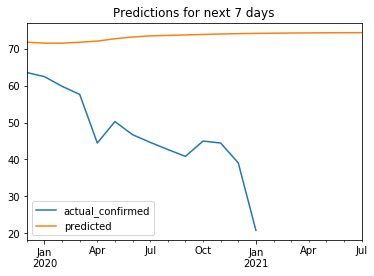

In [6]:
#Create a dataframe to capture the forecast data
df_forecast = pd.DataFrame(columns=["actual_confirmed","predicted"], index=time_series_array)

df_forecast.loc[:,"predicted"] = rescaled_prediction[:,0]
df_forecast.loc[:,"actual_confirmed"] = test["confirmed"]

#Plot
df_forecast.plot(title="Predictions for next 7 days")

In [7]:
display(df_forecast.head(25))

,actual_confirmed,predicted
2019-12-01,63.612903,71.850448
2020-01-01,62.483871,71.592944
2020-02-01,59.862069,71.568940
2020-03-01,57.677419,71.838640
2020-04-01,44.466667,72.141355
2020-05-01,50.290323,72.787287
2020-06-01,46.733333,73.241256
2020-07-01,44.645161,73.571880
2020-08-01,42.709677,73.684399
2020-09-01,40.833333,73.817144
